In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
path='D:\Digesh Personal\Simplilearn\Data-Science-Capstone-Projects\Project_3//'
df = pd.read_excel(path+'online_retail_II.xlsx',
                   dtype={'CustomerID': str,
                          'InvoiceID': str},
                   parse_dates=['InvoiceDate'], 
                   infer_datetime_format=True)

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
df.shape

(525461, 8)

In [4]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [5]:
df.dropna(subset=['Description'], inplace=True)
df.shape

(522533, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522533 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      522533 non-null  object        
 1   StockCode    522533 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     522533 non-null  int64         
 4   InvoiceDate  522533 non-null  datetime64[ns]
 5   Price        522533 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      522533 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 35.9+ MB


In [7]:
df.dropna(subset=['Customer ID'], inplace=True)

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,417534.0,12.758815,101.220424,-9360.0,2.00,4.00,12.00,19152.00
Price,417534.0,3.887547,71.131797,0.0,1.25,1.95,3.75,25111.09
Customer ID,417534.0,15360.645478,1680.811316,12346.0,13983.00,15311.00,16799.00,18287.00


In [9]:
n_orders = df.groupby(['Customer ID'])['Invoice'].nunique()
mult_orders_perc = np.sum(n_orders > 1) / df['Customer ID'].nunique()
print(f'{100 * mult_orders_perc:.2f}% of customers ordered more than once.')

71.09% of customers ordered more than once.


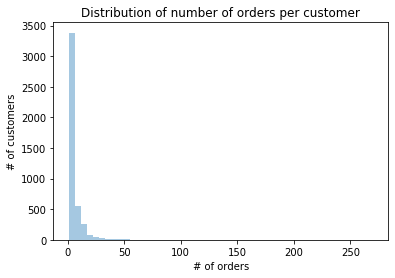

In [10]:
ax = sns.distplot(n_orders, kde=False, hist=True)
ax.set(title='Distribution of number of orders per customer',
       xlabel='# of orders', 
       ylabel='# of customers');

# Cohort Analysis

In [11]:
#drop duplicates
df_cust_inv = df[['Customer ID', 'Invoice', 'InvoiceDate']].drop_duplicates()

In [12]:
df_cust_inv['order_month'] = df_cust_inv['InvoiceDate'].dt.to_period('M')
df_cust_inv['cohort'] = df_cust_inv.groupby('Customer ID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M') 

In [13]:
from operator import attrgetter
df_cohort = df_cust_inv.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('Customer ID', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

In [14]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [15]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

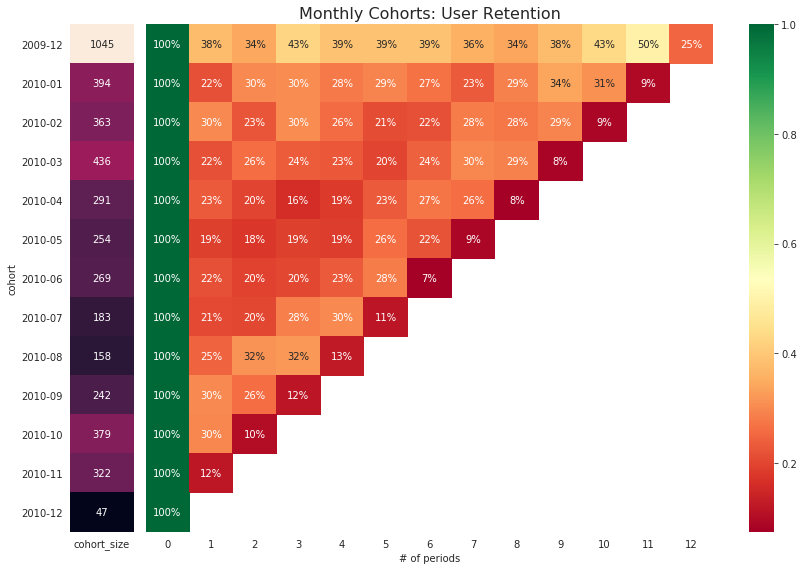

In [16]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    #white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                #cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

In [17]:
df['TotalSale'] = df['Quantity'] * df['Price']
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalSale
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [18]:
df_cust_sale = df[['Customer ID', 'TotalSale', 'InvoiceDate']].drop_duplicates()

In [19]:
df_cust_sale['order_month'] = df_cust_sale['InvoiceDate'].dt.to_period('M')
df_cust_sale['cohort'] = df_cust_sale.groupby('Customer ID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M') 

In [20]:
df_cust_sale.groupby('order_month')['TotalSale'].count()

order_month
2009-12    20630
2010-01    14106
2010-02    14572
2010-03    20102
2010-04    16969
2010-05    18214
2010-06    19308
2010-07    16851
2010-08    16282
2010-09    21035
2010-10    29677
2010-11    36760
2010-12     9209
Freq: M, Name: TotalSale, dtype: int64

In [21]:
df_cohort = df_cust_sale.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('TotalSale', 'sum')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

In [22]:
df_cohort.head()

,cohort,order_month,n_customers,period_number
0,2009-12,2009-12,483013.020,0
1,2009-12,2010-01,276317.271,1
2,2009-12,2010-02,206672.772,2
3,2009-12,2010-03,278739.980,3
4,2009-12,2010-04,219564.810,4


In [23]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [24]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

In [25]:
cohort_size.head()

cohort
2009-12    483013.020
2010-01    105101.251
2010-02    104304.283
2010-03    103923.651
2010-04     64683.621
Freq: M, Name: 0, dtype: float64

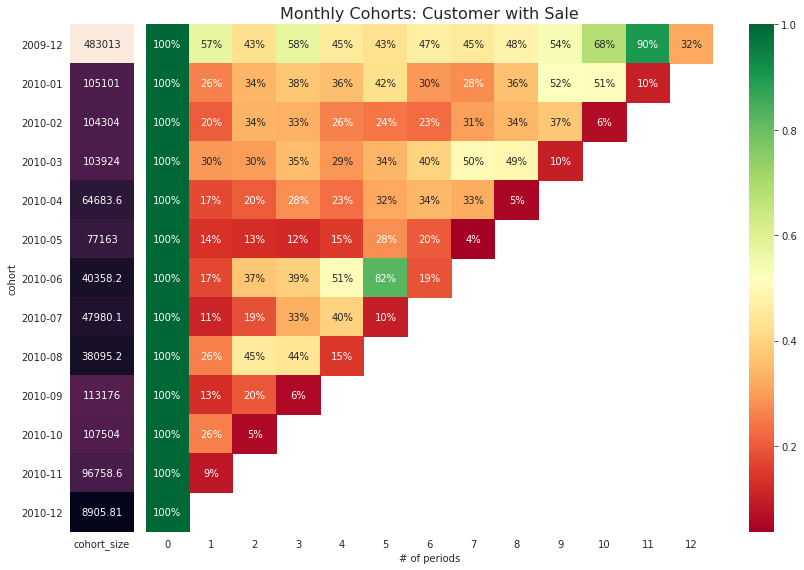

In [26]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: Customer with Sale', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    #white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                #cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

In [27]:
cohort_size_df.head()

,cohort_size
cohort,
2009-12,483013.020
2010-01,105101.251
2010-02,104304.283
2010-03,103923.651
2010-04,64683.621


In [28]:
# drop the row missing customer ID 
online = df[df['Customer ID'].notnull()]
online = online.sample(frac = .3).reset_index(drop = True)
online.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalSale
0,531792,20963,APPLE BATH SPONGE,10,2010-11-09 15:20:00,1.25,14899.0,United Kingdom,12.50
1,496651,85206B,PINK FELT EASTER EGG BASKET,3,2010-02-03 12:21:00,1.65,13553.0,United Kingdom,4.95
2,510649,15039,SANDALWOOD FAN,100,2010-06-02 13:23:00,0.53,14298.0,United Kingdom,53.00
3,505506,84991,60 TEATIME FAIRY CAKE CASES,24,2010-04-22 14:10:00,0.55,16344.0,United Kingdom,13.20
4,489683,48194,DOORMAT HEARTS,2,2009-12-02 10:09:00,6.75,16131.0,United Kingdom,13.50


In [29]:
import datetime as dt
# extract year, month and day
online['InvoiceDay'] = online.InvoiceDate.apply(lambda x: dt.datetime(x.year, x.month, x.day))
online.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalSale,InvoiceDay
0,531792,20963,APPLE BATH SPONGE,10,2010-11-09 15:20:00,1.25,14899.0,United Kingdom,12.50,2010-11-09
1,496651,85206B,PINK FELT EASTER EGG BASKET,3,2010-02-03 12:21:00,1.65,13553.0,United Kingdom,4.95,2010-02-03
2,510649,15039,SANDALWOOD FAN,100,2010-06-02 13:23:00,0.53,14298.0,United Kingdom,53.00,2010-06-02
3,505506,84991,60 TEATIME FAIRY CAKE CASES,24,2010-04-22 14:10:00,0.55,16344.0,United Kingdom,13.20,2010-04-22
4,489683,48194,DOORMAT HEARTS,2,2009-12-02 10:09:00,6.75,16131.0,United Kingdom,13.50,2009-12-02


In [30]:
# print the time period
print('Min : {}, Max : {}'.format(min(online.InvoiceDay), max(online.InvoiceDay)))

Min : 2009-12-01 00:00:00, Max : 2010-12-09 00:00:00


In [31]:
# pin the last date
pin_date = max(online.InvoiceDay) + dt.timedelta(1)

In [32]:
# Create total spend dataframe
online['TotalSum'] = online.Quantity * online.Price
online.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalSale,InvoiceDay,TotalSum
0,531792,20963,APPLE BATH SPONGE,10,2010-11-09 15:20:00,1.25,14899.0,United Kingdom,12.50,2010-11-09,12.50
1,496651,85206B,PINK FELT EASTER EGG BASKET,3,2010-02-03 12:21:00,1.65,13553.0,United Kingdom,4.95,2010-02-03,4.95
2,510649,15039,SANDALWOOD FAN,100,2010-06-02 13:23:00,0.53,14298.0,United Kingdom,53.00,2010-06-02,53.00
3,505506,84991,60 TEATIME FAIRY CAKE CASES,24,2010-04-22 14:10:00,0.55,16344.0,United Kingdom,13.20,2010-04-22,13.20
4,489683,48194,DOORMAT HEARTS,2,2009-12-02 10:09:00,6.75,16131.0,United Kingdom,13.50,2009-12-02,13.50


In [33]:
# calculate RFM values
rfm = online.groupby('Customer ID').agg({
    'InvoiceDate' : lambda x: (pin_date - x.max()).days,
    'Invoice' : 'count', 
    'TotalSum' : 'sum'})
# rename the columns
rfm.rename(columns = {'InvoiceDate' : 'Recency', 
                      'Invoice' : 'Frequency', 
                      'TotalSum' : 'Monetary'}, inplace = True)
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,66,14,-177.95
12347.0,2,23,396.38
12348.0,73,6,85.56
12349.0,42,30,893.54
12351.0,10,6,91.35


In [34]:
# create labels and assign them to tree percentile groups 
r_labels = range(4, 0, -1)
r_groups = pd.qcut(rfm.Recency, q = 4, labels = r_labels)
f_labels = range(1, 5)
f_groups = pd.qcut(rfm.Frequency, q = 4, labels = f_labels)
m_labels = range(1, 5)
m_groups = pd.qcut(rfm.Monetary, q = 4, labels = m_labels)

In [35]:
# make a new column for group labels
rfm['R'] = r_groups.values
rfm['F'] = f_groups.values
rfm['M'] = m_groups.values
# sum up the three columns
rfm['RFM_Segment'] = rfm.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']), axis = 1)
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis = 1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
Customer ID,,,,,,,,
12346.0,66,14,-177.95,2,2,1,221,5.0
12347.0,2,23,396.38,4,3,3,433,10.0
12348.0,73,6,85.56,2,1,1,211,4.0
12349.0,42,30,893.54,3,3,4,334,10.0
12351.0,10,6,91.35,4,1,2,412,7.0


In [36]:
# calculate averae values for each RFM
rfm_agg = rfm.groupby('RFM_Score').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'Monetary' : ['mean', 'count']
})
rfm_agg.round(1).head()

Recency Frequency Monetary      
             mean      mean     mean count
RFM_Score                                 
3.0         254.2       2.9    -21.1   385
4.0         177.7       5.0     35.7   372
5.0         137.0       7.0    105.3   475
6.0          90.5       9.2    196.3   447
7.0          83.7      13.5    255.0   460

In [37]:
# assign labels from total score
score_labels = ['Green', 'Bronze', 'Silver', 'Gold']
score_groups = pd.qcut(rfm.RFM_Score, q = 4, labels = score_labels)
rfm['RFM_Level'] = score_groups.values
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
Customer ID,,,,,,,,,
12346.0,66,14,-177.95,2,2,1,221,5.0,Green
12347.0,2,23,396.38,4,3,3,433,10.0,Silver
12348.0,73,6,85.56,2,1,1,211,4.0,Green
12349.0,42,30,893.54,3,3,4,334,10.0,Silver
12351.0,10,6,91.35,4,1,2,412,7.0,Bronze


In [38]:
rfm['RFM_Level'].value_counts()

Silver    1274
Green     1232
Bronze     907
Gold       780
Name: RFM_Level, dtype: int64

In [39]:
# define function for the values below 0
def neg_to_zero(x):
    if x <= 0:
        return 1
    else:
        return x
# apply the function to Recency and MonetaryValue column 
rfm['Recency'] = [neg_to_zero(x) for x in rfm.Recency]
rfm['Monetary'] = [neg_to_zero(x) for x in rfm.Monetary]
# unskew the data
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

In [40]:
from sklearn.preprocessing import StandardScaler
# scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
# transform into a dataframe
rfm_scaled = pd.DataFrame(rfm_scaled, index = rfm.index, columns = rfm_log.columns)

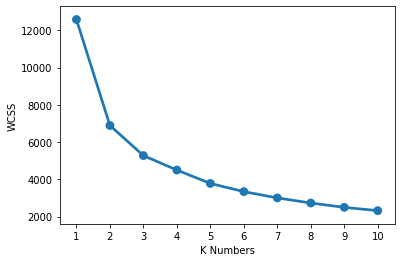

In [41]:
from sklearn.cluster import KMeans
# the Elbow method
wcss = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters= k, init= 'k-means++', max_iter= 300)
    kmeans.fit(rfm_scaled)
    wcss[k] = kmeans.inertia_
# plot the WCSS values
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.xlabel('K Numbers')
plt.ylabel('WCSS')
plt.show()

In [42]:
# clustering
clus = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 300)
clus.fit(rfm_scaled)
# Assign the clusters to datamart
rfm['K_Cluster'] = clus.labels_
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
Customer ID,,,,,,,,,,
12346.0,66,14,1.00,2,2,1,221,5.0,Green,0
12347.0,2,23,396.38,4,3,3,433,10.0,Silver,1
12348.0,73,6,85.56,2,1,1,211,4.0,Green,0
12349.0,42,30,893.54,3,3,4,334,10.0,Silver,2
12351.0,10,6,91.35,4,1,2,412,7.0,Bronze,2


In [43]:
rfm['K_Cluster'].value_counts()

2    1924
0    1233
1    1036
Name: K_Cluster, dtype: int64

In [44]:
# clustering
clus = KMeans(n_clusters= 5, init= 'k-means++', max_iter= 300)
clus.fit(rfm_scaled)
# Assign the clusters to datamart
rfm['K_Cluster_5'] = clus.labels_
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster,K_Cluster_5
Customer ID,,,,,,,,,,,
12346.0,66,14,1.00,2,2,1,221,5.0,Green,0,1
12347.0,2,23,396.38,4,3,3,433,10.0,Silver,1,3
12348.0,73,6,85.56,2,1,1,211,4.0,Green,0,2
12349.0,42,30,893.54,3,3,4,334,10.0,Silver,2,0
12351.0,10,6,91.35,4,1,2,412,7.0,Bronze,2,4


In [45]:
rfm['K_Cluster_5'].value_counts()

2    1269
0    1052
4     718
3     639
1     515
Name: K_Cluster_5, dtype: int64

# Snake plot and heatmap

In [46]:
# assign cluster column 
rfm_scaled['K_Cluster'] = clus.labels_
rfm_scaled['RFM_Level'] = rfm['RFM_Level']
rfm_scaled.reset_index(inplace = True)
# melt the dataframe
rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['Customer ID', 'RFM_Level', 'K_Cluster'], var_name = 'Metrics', value_name = 'Value')
rfm_melted.head()

,Customer ID,RFM_Level,K_Cluster,Metrics,Value
0,12346.0,Green,1,Recency,0.305180
1,12347.0,Silver,3,Recency,-2.064306
2,12348.0,Green,2,Recency,0.372937
3,12349.0,Silver,0,Recency,-0.001085
4,12351.0,Bronze,4,Recency,-0.973407


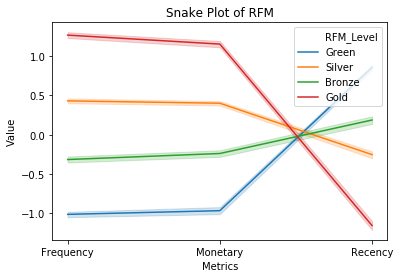

In [47]:
# a snake plot with RFM
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'RFM_Level', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')

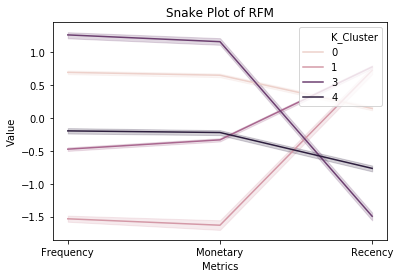

In [48]:
# a snake plot with K-Means
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'K_Cluster', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')

[]

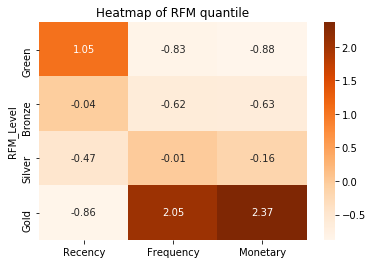

In [49]:
# the mean value in total 
total_avg = rfm.iloc[:, 0:3].mean()
total_avg
# calculate the proportional gap with total mean
cluster_avg = rfm.groupby('RFM_Level').mean().iloc[:, 0:3]
prop_rfm = cluster_avg/total_avg - 1
# heatmap with RFM
sns.heatmap(prop_rfm, cmap= 'Oranges', fmt= '.2f', annot = True)
plt.title('Heatmap of RFM quantile')
plt.plot()

[]

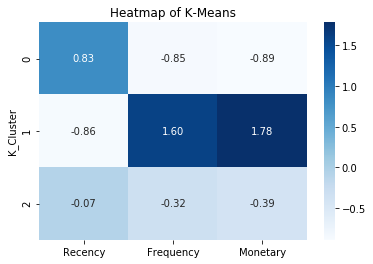

In [50]:
# calculate the proportional gap with total mean
cluster_avg_K = rfm.groupby('K_Cluster').mean().iloc[:, 0:3]
prop_rfm_K = cluster_avg_K/total_avg - 1
# heatmap with K-means
sns.heatmap(prop_rfm_K, cmap= 'Blues', fmt= '.2f', annot = True)
plt.title('Heatmap of K-Means')
plt.plot()

[]

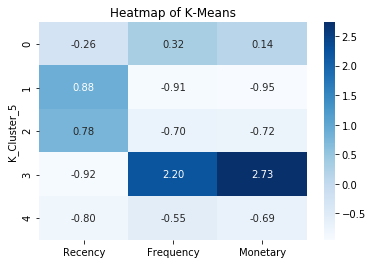

In [51]:
# calculate the proportional gap with total mean
cluster_avg_K = rfm.groupby('K_Cluster_5').mean().iloc[:, 0:3]
prop_rfm_K = cluster_avg_K/total_avg - 1
# heatmap with K-means
sns.heatmap(prop_rfm_K, cmap= 'Blues', fmt= '.2f', annot = True)
plt.title('Heatmap of K-Means')
plt.plot()